# Hovmoller Temperature Depth

This notebook shows how to calculate a depth-time Hovmoller plot of 30-year anomalies of globally averaged of conservative temperature, practical salinity from ACCESS-OM2 between Jan 1989 and Dec 2018.

In [1]:
import numpy as np
import xarray as xr
import cf_xarray as cfxr
import intake

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
import cmocean.cm as cm

from dask.distributed import Client

In [2]:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 48
Total threads: 48,Total memory: 188.56 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35241,Workers: 48
Dashboard: /proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 188.56 GiB
Comm: tcp://127.0.0.1:38145,Total threads: 1
Dashboard: /proxy/42553/status,Memory: 3.93 GiB
Nanny: tcp://127.0.0.1:43035,


In [3]:
catalog = intake.cat.access_nri

experiment = '1deg_jra55_iaf_omip2_cycle1'  # 1-deg experiment

start_time, end_time = '1989-01-01', '2018-12-31'

In [4]:
def load_var(experiment, variable, frequency, start_time, end_time):
    cat_subset = catalog.search(name = experiment)
    var = cat_subset[experiment].search(
        variable = variable,frequency = frequency,variable_cell_methods='time: mean'
        ).to_dask(xarray_open_kwargs=dict(use_cftime=True,chunks={}),
                  xarray_combine_by_coords_kwargs=dict(compat="override",data_vars="minimal",coords="minimal")
                 )[variable]

    var = var.sel(time=slice(start_time, end_time))

    return var

Loading the variables

In [5]:
## Loading the variables
temperature = load_var(experiment, 'temp', '1mon', start_time, end_time)
salinity = load_var(experiment, 'salt', '1mon', start_time, end_time)

Compute anomalies relative to the 30-year time average

In [6]:
temperature_anomaly = temperature - temperature.cf.mean('time')
salinity_anomaly = salinity - salinity.cf.mean('time')

Next, we load cell area (denoted $a(x,y,z)$) to construct the total ocean area as a function of depth, $A$, namely
$$ A(z) = \sum_x \sum_y a(x,y,z)$$


We load `dxt` and `dyt` and compute a masked version of cell area; we also use a slight hack to divide temperature by itself and thereby get a 3-dimensional cell area (which is needed to create $A(z)$

In [8]:
cat_subset = catalog.search(name = experiment)
dxt = cat_subset[experiment].search(variable = 'dxt',frequency = 'fx',path=".*output000.*").to_dask()['dxt']
dyt = cat_subset[experiment].search(variable = 'dyt',frequency = 'fx',path=".*output000.*").to_dask()['dyt']
cell_area = dxt * dyt

## Make a mask to get vertical variation of A
temp1 = temperature.isel(time=0)
cell_mask = temp1/temp1
total_area = (cell_area*cell_mask).cf.sum({'longitude', 'latitude'})
total_area.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
 

<xarray.DataArray (st_ocean: 50)> Size: 200B
array([3.6157618e+14, 3.6157618e+14, 3.6157618e+14, 3.6157618e+14,
       3.6006838e+14, 3.5906635e+14, 3.5804575e+14, 3.5675314e+14,
       3.5520326e+14, 3.5344115e+14, 3.5184432e+14, 3.4986975e+14,
       3.4810176e+14, 3.4635307e+14, 3.4449181e+14, 3.4311246e+14,
       3.4172038e+14, 3.4014027e+14, 3.3872531e+14, 3.3723667e+14,
       3.3557683e+14, 3.3394367e+14, 3.3231098e+14, 3.3054682e+14,
       3.2860104e+14, 3.2690701e+14, 3.2517100e+14, 3.2350935e+14,
       3.2163386e+14, 3.1968817e+14, 3.1720645e+14, 3.1477446e+14,
       3.1172993e+14, 3.0821061e+14, 3.0446510e+14, 3.0049091e+14,
       2.9531105e+14, 2.8988167e+14, 2.8245903e+14, 2.7252349e+14,
       2.5959445e+14, 2.4312340e+14, 2.2356598e+14, 2.0135751e+14,
       1.7715136e+14, 1.5123962e+14, 1.2405084e+14, 9.9180895e+13,
       7.4502734e+13, 4.8844402e+13], dtype=float32)
Coordinates:
    time      object 8B 1989-01-14 12:00:00
  * st_ocean  (st_ocean) float64 400B 1.152 3.649 6.565 ... 5.034e+03 5.254e+03

Now, the mean temperature at each time level can then be computed as 
$$T(z,t) = \frac{\sum_x \sum_y a(x,y,z) \, \tilde{\theta}(x,y,z,t)}{A(z)}$$
where $T$ is the globally average temperature and $\tilde{\theta}$ is the anomaly of the conservative temperature.

In [9]:
### Temperature hovmoller
temperature_hov = (cell_area * temperature_anomaly).cf.sum({'longitude', 'latitude'}) / total_area
temperature_hov = temperature_hov.compute()

### Salinity hovmoller
salinity_hov = (cell_area * salinity_anomaly).cf.sum({'longitude', 'latitude'}) / total_area
salinity_hov = salinity_hov.compute()

In [10]:
def plot_hovmuller(fsize = 14, date_format = mdates.DateFormatter('%Y')):
    # Set figures properties
    plt.rcParams['font.size'] = fsize
    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams['xtick.labelsize'] = fsize
    plt.rcParams['ytick.labelsize'] = fsize
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titleweight'] = 'bold'
    
    fig = plt.figure(figsize = (10, 6))
    grid = GridSpec(100, 100)
    
    ax = [fig.add_subplot(grid[:30, :30]), fig.add_subplot(grid[:30, 33:63]),
          fig.add_subplot(grid[32:, :30]), fig.add_subplot(grid[32:, 33:63])]
    
    for i in range(len(ax)):
        ax[i].xaxis.set_major_formatter(date_format)
        ax[i].tick_params(axis='x', labelrotation=45)
        if i != 0 and i != 2:
            ax[i].set_yticklabels([]) 
    
    return fig, ax

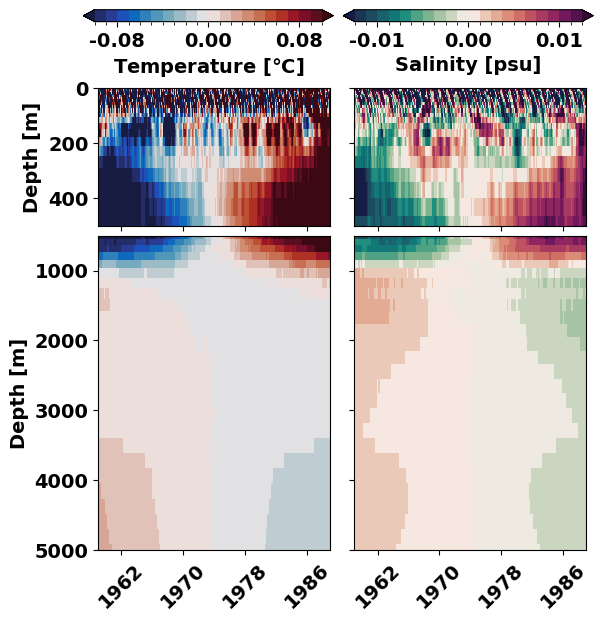

In [11]:
fig, ax = plot_hovmuller(fsize = 14)

levels_temperature = np.arange(-0.1, 0.11, 0.01)

cf_temp = temperature_hov.cf.plot(ax = ax[0], levels = levels_temperature,
                                  x = 'time',  y = 'vertical',
                                  add_colorbar = False, label = None, cmap = cm.balance, extend = 'both')
temperature_hov.cf.plot(ax = ax[2], levels = levels_temperature,
                        x = 'time', y = 'vertical',
                        add_colorbar = False, label = None, cmap = cm.balance, extend = 'both')


levels_salinity = np.arange( -0.01, 0.011, 0.001)

cf_salt = salinity_hov.cf.plot(ax = ax[1], levels = levels_salinity,
                               x = 'time', y = 'vertical',
                               add_colorbar = False, label = None, cmap = cm.curl, extend = 'both')
salinity_hov.cf.plot(ax = ax[3], levels = levels_salinity,
                     x = 'time', y = 'vertical',
                     add_colorbar = False, label = None, cmap = cm.curl, extend = 'both')

## Details
for i in range(len(ax)):
    if i < 2:
        ax[i].set_ylim(500, 0)
        ax[i].set_xticklabels([])
    else:
        ax[i].set_xlabel('')
        ax[i].set_ylim(5000, 500)
ax[0].set_ylabel("Depth [m]")
ax[1].set_ylabel('')
ax[2].set_ylabel("Depth [m]")
ax[3].set_ylabel('')

# Colorbars
bar = plt.axes([0.11, 0.99, 0.25, 0.02])
cbar_1 = plt.colorbar(cf_temp, cax = bar, orientation = 'horizontal', extend='both', format= '%.2f')  
cbar_1.set_label('Temperature [$\degree$C]')

bar = plt.axes([0.37, 0.99, 0.25, 0.02])
cbar_2 = plt.colorbar(cf_salt, cax = bar, orientation = 'horizontal', extend='both', format= '%.2f')  
cbar_2.set_label('Salinity [psu]')

cbar = [cbar_1, cbar_2]
for i in range(len(cbar)):
    tick_locator = ticker.MaxNLocator(nbins=3) ## The ticker needs to called within the loop
    cbar[i].locator = tick_locator
    cbar[i].update_ticks()